In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Import data

In [ ]:
## Defined functions

def convert_drugs(value):
    """
    Clean up weird values for drugs text box
    :param value: value to convert
    :return: categegorical value
    """
    if value == "Caffeine (energy drinks/coffee)" or \
        value == "Caffeine (energy drinks/coffee), Kohvi on elu, kohvi on armastus :) " or \
        value == "Herbal tea" or value == 'herbal tea' or value == "tee":
        return "Caffeine"
    elif value.startswith("Ei") or value == "No" or value == "no" or value == "food" or value == "sweets":
        return "No"
    return value


def merge_ids(id, *other_ids):
    for other_id in other_ids:
        common["user_id"].loc[common["user_id"] == other_id] = id
        general.rename(index={other_id: id}, inplace=True)


def remove_users(ids):
    global common, general
    for i in ids:
        common = common[common["user_id"] != i]
        general.drop(i, inplace=True, errors="ignore")




In [ ]:
## Read data in

general = pd.read_csv("out_general.csv", names=["row", "ts", "user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     usecols=["user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     header=0, 
                     dtype={'gender':'category', 
                            'age':'category', 
                            'prev_test':'category', 
                            'pys_activity':'category', 
                            'sick':'category', 
                            'pain_general':'category', 
                            'pain_digest':'category', 
                            'sleep_regular':'category'
                           },
                      index_col=0)
common = pd.read_csv("out_common.csv", names=["ts", "user_id", "res_number", "res_reaction", "res_visual", "hungry", "sleepy", "time_sleep", "time_wake", "stress",
                                              "fatigue_mental", "fatigue_physical", "drugs"], header=0, 
                     converters={'ts':lambda v: pd.Timestamp(v), 
                                 'time_sleep':lambda v: pd.to_timedelta(v), 
                                 'time_wake':lambda v: pd.to_timedelta(v),
                                 'drugs': convert_drugs},
                     dtype={'hungry':'category', 
                            'sleepy':'category', 
                            'stress':'category', 
                            'fatigue_mental':'category', 
                            'fatigue_physical':'category'})

common["drugs"] = common["drugs"].astype('category')

In [ ]:
any(common.user_id == 23)

False

In [119]:
## Cleanup users

### Merge misspelled usernames
pd.set_option("mode.chained_assignment", None)

merge_ids(1, 29, 33, 34, 36)
merge_ids(35, 37)
merge_ids(4, 13, 7)
merge_ids(17, 41)
merge_ids(10, 38)
merge_ids(8, 40)
merge_ids(18, 45)

# noinspection PyUnreachableCode
if False:
    ### Remove users with various faults
    remove_users([10, 14, 18])

    ### Remove users with too much stress
    stress_ids = common[(common["stress"] == '4') | (common["stress"] == '5')]["user_id"].unique()
    remove_users(stress_ids)

    ## Remove sick people
    sick_people_ids = general[general["sick"] == "Yes"]["user_id"].unique()
    remove_users(sick_people_ids)

common = common.reset_index(drop=True)
general.sort_index(inplace=True)

# filter people who either failed at filling out general or didn't do any tests
empty_ids = set(common.user_id.unique()) ^ set(general.index)
remove_users(empty_ids)

# remove people who did less than 4 tests TODO maybe more?
test_counts = common["user_id"].value_counts()
almost_empty_ids = test_counts[test_counts < 4].index
remove_users(almost_empty_ids)

## Normalize scores

In [ ]:
from sklearn import preprocessing

columns = ["res_reaction", "res_visual", "res_number"]

for c in columns:
    scaler = preprocessing.MinMaxScaler()
    common[[c]] = scaler.fit_transform(common[[c]])

# reaction time is better the smaller it is, so we need to flip it
common.res_reaction = 1-common.res_reaction

In [83]:
## Too few rows of hungry level 4 and 5 to draw conclusions 

hungry_level_1 = \
    common.loc[common["hungry"] == '1', ["res_number", "res_reaction", "res_visual"]]
hungry_level_2 = \
    common.loc[common["hungry"] == '2', ["res_number", "res_reaction", "res_visual"]]
hungry_level_3 = \
    common.loc[common["hungry"] == '3', ["res_number", "res_reaction", "res_visual"]]
hungry_level_4 = \
    common.loc[common["hungry"] == '4', ["res_number", "res_reaction", "res_visual"]]
hungry_level_5 = \
    common.loc[common["hungry"] == '5', ["res_number", "res_reaction", "res_visual"]]

grouped_hungry_subjects = \
    common[["user_id", "hungry", "res_number", "res_visual", "res_reaction"]]\
        .groupby(["user_id", "hungry"]).mean()\
        .groupby("hungry").mean()

In [23]:
def draw_bar_plot(plot, title, x_axis_list, y_axis_list):
    plot.set_title(title)

    for i in range(0, len(x_axis_list)):
        plot.bar(x_axis_list[i], y_axis_list[i], align = "center")


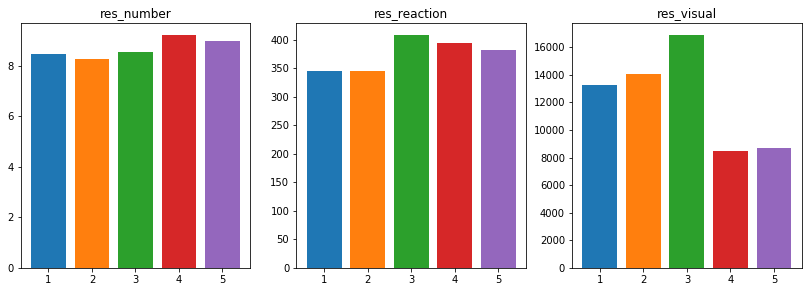

In [28]:
## Average results over all entries

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize = (14, 4.5)) 

draw_bar_plot(plt1, "res_number", ['1', '2', '3', '4', '5'], [
    round(hungry_level_1["res_number"].mean(), 2), 
    round(hungry_level_2["res_number"].mean(), 2),
    round(hungry_level_3["res_number"].mean(), 2),
    round(hungry_level_4["res_number"].mean(), 2),
    round(hungry_level_5["res_number"].mean(), 2)
    ])

draw_bar_plot(plt2, "res_reaction", ['1', '2', '3', '4', '5'], [
    round(hungry_level_1["res_reaction"].mean(), 2), 
    round(hungry_level_2["res_reaction"].mean(), 2),
    round(hungry_level_3["res_reaction"].mean(), 2),
    round(hungry_level_4["res_reaction"].mean(), 2),
    round(hungry_level_5["res_reaction"].mean(), 2)
    ])

draw_bar_plot(plt3, "res_visual", ['1', '2', '3', '4', '5'], [
    round(hungry_level_1["res_visual"].mean(), 2), 
    round(hungry_level_2["res_visual"].mean(), 2),
    round(hungry_level_3["res_visual"].mean(), 2),
    round(hungry_level_4["res_visual"].mean(), 2),
    round(hungry_level_5["res_visual"].mean(), 2)
    ])

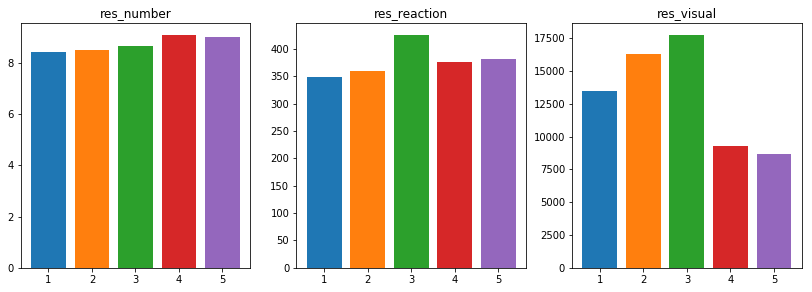

In [29]:
## Average results of averaged subjects results

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize = (14, 4.5)) 

draw_bar_plot(plt1, "res_number", ['1', '2', '3', '4', '5'], [
    grouped_hungry_subjects["res_number"][0], 
    grouped_hungry_subjects["res_number"][1],
    grouped_hungry_subjects["res_number"][2],
    grouped_hungry_subjects["res_number"][3],
    grouped_hungry_subjects["res_number"][4]
    ])

draw_bar_plot(plt2, "res_reaction", ['1', '2', '3', '4', '5'], [
    grouped_hungry_subjects["res_reaction"][0], 
    grouped_hungry_subjects["res_reaction"][1],
    grouped_hungry_subjects["res_reaction"][2],
    grouped_hungry_subjects["res_reaction"][3],
    grouped_hungry_subjects["res_reaction"][4]
    ])

draw_bar_plot(plt3, "res_visual", ['1', '2', '3', '4', '5'], [
    grouped_hungry_subjects["res_visual"][0], 
    grouped_hungry_subjects["res_visual"][1],
    grouped_hungry_subjects["res_visual"][2],
    grouped_hungry_subjects["res_visual"][3],
    grouped_hungry_subjects["res_visual"][4]
    ])

In [ ]:

common[["user_id", "hungry", "res_number", "res_visual", "res_reaction"]].groupby(["user_id", "hungry"]).mean().groupby("hungry").mean()

## Add time from wakeup

In [ ]:

# add awake delta
ts_wake = common.ts.apply(lambda x: x.replace(hour=0, minute=0, second=0)) + common.time_wake
delta = ((common.ts - ts_wake) + pd.Timedelta(days=1)) % pd.Timedelta(days=1)
# common["awake_delta"] = delta / np.timedelta64(1, 's')

# bin deltas into 1h boxes
#pd.cut(delta)
#delta = pd.timedelta_range(start="0 hour" , freq="1H", periods=25, closed="right")
common['awake_bin'] = [r.seconds // 3600 + 1 for r in delta]
#common

# fine best time per person 
res = common[["user_id", "res_number", "res_visual", "res_reaction"]]
best = res.groupby("user_id").idxmax()

assert best.index.all(general.index)
for c in columns:
    bins = common.loc[best[c]][["awake_bin", "user_id"]]
    bins = bins.set_index("user_id")
    general["best_" + c] = bins

In [ ]:
# Andrews Curves
from pandas.plotting import andrews_curves


#long_res = pd.wide_to_long(res, "res", i="id", j="game_type", suffix="\w+", sep="_").reset_index()

#del long_res["id"]
#means = long_res.groupby(["user_id", "game_type"]).mean().reset_index()
#del means["user_id"]

andrews_curves(res, "user_id")

#fig, plots = plt.subplots(1, 3, figsize = (14, 4.5))

#for column,plot in zip(columns,plots) :
    #res[column].plot.bar(ax=plot)



In [ ]:
# Growth of player
res.groupby("user_id")[columns].plot()

In [ ]:
#

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols



In [ ]:
model = ols("res_number ~ awake_delta", common).fit()
model.summary()

In [ ]:
fig,plots  = plt.subplots(1,1)
fig = sm.graphics.plot_partregress_grid(model, fig=fig)